# Demo how to make predictions with OSnet lib, using all built-in default variables

Requires cartopy and argopy

In [1]:
import os, sys, glob
import pandas as pd
import xarray as xr
import numpy as np

sys.path.insert(0, "/Users/gmaze/git/github/euroargodev/OSnet-GulfStream")  # Adjust to your path pointing to the osnbert library folder
# sys.path.insert(0, "/home1/datahome/gmaze/git/github/euroargodev/OSnet-GulfStream")  # Adjust to your path pointing to the osnbert library folder
import osnet
from osnet.options import OPTIONS
osnet.disclaimer()
OPTIONS

{'mdt': 'mdt-cnes-cls18-GulfStream.nc',
 'bathymetry': 'bathymetry-GulfStream.nc',
 'sst_clim': 'SST_Gulf_Stream_Climato.nc',
 'sla_clim': 'SLA_Gulf_Stream_Climato.nc',
 'domain': [-80, -30, 23, 50],
 'unbound': False}

In [2]:
# For plots
xr.set_options(display_style="html", display_expand_attrs=False);
import matplotlib.pyplot as plt
import colorcet as cc
import cmocean
import time

# Dictionnary of colormaps for variables
cmapd = {'BATHY': cmocean.cm.topo, 
      'MDT': cmocean.cm.delta, 
      'SST': cmocean.cm.thermal, 
      'SLA': cmocean.cm.balance, 
      'UGOSA': cmocean.cm.balance, 
      'VGOSA': cmocean.cm.balance, 
      'UGOS': cmocean.cm.balance,
      'VGOS': cmocean.cm.balance,
      'temp': cmocean.cm.thermal, 
      'temp_adj': cmocean.cm.thermal, 
      'temp_std': cmocean.cm.amp, 
      'psal': cmocean.cm.haline, 
      'psal_adj': cmocean.cm.haline, 
      'psal_std': cmocean.cm.amp, 
      'sig': cmocean.cm.dense, 
      'sig_adj': cmocean.cm.dense, 
      'sig_std': cmocean.cm.amp, 
      'mld': cc.cm["rainbow"]
     }

import argopy
import cartopy.crs as ccrs

def plot_map(this_ax):
    """
        >>> fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6), dpi=90, subplot_kw={"projection": ccrs.PlateCarree()})
        >>> plot_map(ax)
    """
    this_ax.add_feature(argopy.plotters.land_feature, edgecolor="black")
    this_ax.set_xlim(osnet.utilities.conv_lon(OPTIONS['domain'][0])-1, osnet.utilities.conv_lon(OPTIONS['domain'][1])+1)
    this_ax.set_ylim(OPTIONS['domain'][2]-1, OPTIONS['domain'][3]+1)
    argopy.plotters.latlongrid(this_ax, dx="auto", dy="auto", fontsize="auto");
    return this_ax

In [3]:
# Versions:
# osnet.show_versions()

# Load OSnet model

In [4]:
%%time
m = osnet.load('Gulf-Stream')
m

/Users/gmaze/anaconda/envs/OSnet/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
2022-02-25 13:38:59.483556: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


CPU times: user 3.86 s, sys: 126 ms, total: 3.99 s
Wall time: 3.99 s


<osnet.GulfStream>
Reference: Pauthenet et al, 2022 (http://dx.doi.org/...)
Models: 15 instance(s) in the ensemble
MLD adjusted: True

# Make a collection of input grid to make prediction for

In [5]:
input_list = {}

## 1D station

In [6]:
ds_in = xr.Dataset({}, coords={
    'lon': (['lon'], np.array(-54)[np.newaxis]),
    'lat': (['lat'], np.array(35)[np.newaxis]),
    'time': np.array(np.datetime64('2005-11-30'))[np.newaxis]
})
input_list['station'] = ds_in

## 2D local timeseries

In [7]:
x = np.array(360-54)[np.newaxis]
y = np.array(35)[np.newaxis]
t = pd.date_range("1998-09-01", "2000-08-31", freq='M')

ds_in = xr.Dataset({}, coords={
    'lon': (['lon'], x),
    'lat': (['lat'], y),
    'time': t
})
input_list['local_timeseries'] = ds_in

## 2D horizonal snapshot

In [8]:
# OPTIONS['domain'] = [360-80, 360-30, 23, 50]
# OPTIONS['domain'] = [360-80, 360-30, 23, 50]

x = np.arange(OPTIONS['domain'][0]-1, OPTIONS['domain'][1]+1, 1/2)
y = np.arange(OPTIONS['domain'][2]-1, OPTIONS['domain'][3]+1, 1/2)
t = np.array(np.datetime64('2005-11-30'))[np.newaxis]

ds_in = xr.Dataset({}, coords={
    'lon': (['lon'], x),
    'lat': (['lat'], y),
    'time': t
})
input_list['snapshot'] = ds_in

## 2D meridional transect

In [9]:
x = np.array(-54)[np.newaxis]
y = np.arange(OPTIONS['domain'][2]-1, OPTIONS['domain'][3]+1, 1/2)
t = np.array(np.datetime64('2009-02-12'))[np.newaxis]

ds_in = xr.Dataset({}, coords={
    'lon': (['lon'], x),
    'lat': (['lat'], y),
    'time': t
})
input_list['meridional_transect'] = ds_in

## 2D zonal transect

In [10]:
x = np.arange(OPTIONS['domain'][0]-1, OPTIONS['domain'][1]+1, 1/2)
y = np.array(36.)[np.newaxis]
t = np.array(np.datetime64('2005-02-12'))[np.newaxis]

ds_in = xr.Dataset({}, coords={
    'lon': (['lon'], x),
    'lat': (['lat'], y),
    'time': t
})
input_list['zonal_transect'] = ds_in

## 2D Along Argo float trajectory

In [11]:
from argopy import DataFetcher as argo

# ds_float = argo(cache=True).float(4902503).data.argo.point2profile()
ds_float = argo(cache=True).float(3901602).data.argo.point2profile()
# ds_float = argo(cache=True).float(4902321).data.argo.point2profile()
# ds_float = argo(cache=True).float(4902324).data.argo.point2profile()

ds_in = xr.Dataset({}, coords={
    'sampling': (['sampling'], ds_float['N_PROF'].data),
    'lon': (['sampling'], ds_float['LONGITUDE'].data),
    'lat': (['sampling'], ds_float['LATITUDE'].data),
    'time': (['sampling'], ds_float['TIME'].data),
    'CYCLE_NUMBER': (['sampling'], ds_float['CYCLE_NUMBER'].data),  # Just for easy plotting of output
})
input_list['argo_float'] = ds_in

# Make predictions for all inputs

In [12]:
output_list = {}
for key, ds_in in input_list.items():
    print("Make predictions for: %s" % key)
    start = time.time()
    output_list[key] = m.predict(ds_in)
    Nsample = output_list[key].attrs['OSnet-Nsample']
    dt = time.time() - start
    print("\tdone in %0.3f secs (%0.3f ms/N, with N=%i)" % (dt, dt/Nsample*1e3, Nsample))
    # # ds_out = m.predict(ds_in, inplace=False)
    # # ds_out = m.predict(ds_in, keep_added=True)
    # # ds_out = m.predict(ds_in, keep_added=True, adjust_mld=False)
    # # ds_out = m.predict(ds_in, scaled=False)

Make predictions for: station
	done in 2.143 secs (2143.383 ms/N, with N=1)
Make predictions for: local_timeseries
	done in 1.453 secs (60.532 ms/N, with N=24)
Make predictions for: snapshot
	done in 3.402 secs (0.745 ms/N, with N=4566)
Make predictions for: meridional_transect
	done in 1.506 secs (32.039 ms/N, with N=47)
Make predictions for: zonal_transect
	done in 1.470 secs (16.154 ms/N, with N=91)
Make predictions for: argo_float
	done in 1.428 secs (7.804 ms/N, with N=183)


In [13]:
output_list[key]

<xarray.Dataset>
Dimensions:            (sampling: 183, PRES_INTERPOLATED: 51)
Coordinates:
  * sampling           (sampling) int64 0 1 2 3 4 5 ... 177 178 179 180 181 182
    lon                (sampling) float64 -61.43 -61.84 -62.64 ... -65.16 -65.41
    lat                (sampling) float64 42.51 42.42 42.33 ... 42.35 42.2 41.98
    time               (sampling) datetime64[ns] 2016-09-19T11:26:57 ... 2021...
    CYCLE_NUMBER       (sampling) int64 1 2 3 4 5 6 ... 178 179 180 181 182 183
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 1 2 3 4 ... 773 857 950 1000
Data variables:
    sig_adj            (sampling, PRES_INTERPOLATED) float64 23.6 23.6 ... 27.75
    mld                (sampling) int64 14 14 14 16 19 22 ... 12 12 12 12 12 12
    temp               (sampling, PRES_INTERPOLATED) float32 12.83 ... 4.013
    temp_std           (sampling, PRES_INTERPOLATED) float32 0.3185 ... 0.1762
    psal               (sampling, PRES_INTERPOLATED) float32 31.29 ... 34.94
    sig                (sampling, PRES_INTERPOLATED) float64 23.56 ... 27.75
    temp_adj           (sampling, PRES_INTERPOLATED) float64 12.84 ... 4.013
    psal_adj           (sampling, PRES_INTERPOLATED) float64 31.35 ... 34.94
    psal_std           (sampling, PRES_INTERPOLATED) float32 0.1266 ... 0.02615
Attributes: (2)

# Figures for output

## 1D station

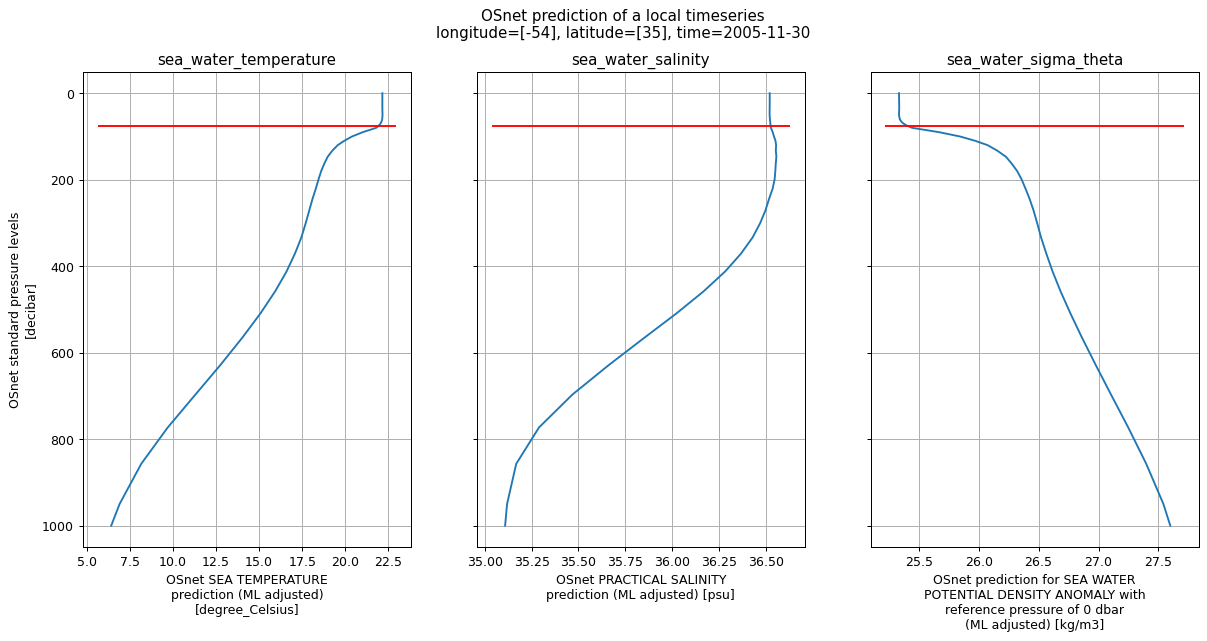

In [14]:
ds_out = output_list['station']

if 'temp_adj' in ds_out:
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(16,7), dpi=90, sharex=False, sharey=True)
    ax = np.array(ax).flatten()
    vlist = ['temp_adj', 'psal_adj', 'sig_adj']
else:
    fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(20,7), dpi=90, sharex=False, sharey=True)
    ax = np.array(ax).flatten()
    vlist = ['temp', 'psal']
    
for i, v in enumerate(vlist):
    this = ds_out[v].isel(lat=0, lon=0, time=0)
    this.plot(y='PRES_INTERPOLATED', ax=ax[i], yincrease=False)
    ax[i].hlines(ds_out['mld'].isel(lat=0, lon=0, time=0), ax[i].get_xlim()[0], ax[i].get_xlim()[-1], 'r')
    ax[i].set_ylabel('')
    ax[i].set_title("%s" % this.attrs['standard_name'])
    ax[i].grid()
ax[0].set_ylabel("%s\n[%s]" % (ds_out['PRES_INTERPOLATED'].attrs['long_name'], ds_out['PRES_INTERPOLATED'].attrs['units']))

fig.suptitle('OSnet prediction of a local timeseries\nlongitude=%s, latitude=%s, time=%s' % (ds_out['lon'].data, 
                                                                                             ds_out['lat'].data, 
                                                                                             pd.to_datetime(ds_out['time'].values[0]).strftime('%Y-%m-%d')));

## 2D local timeseries

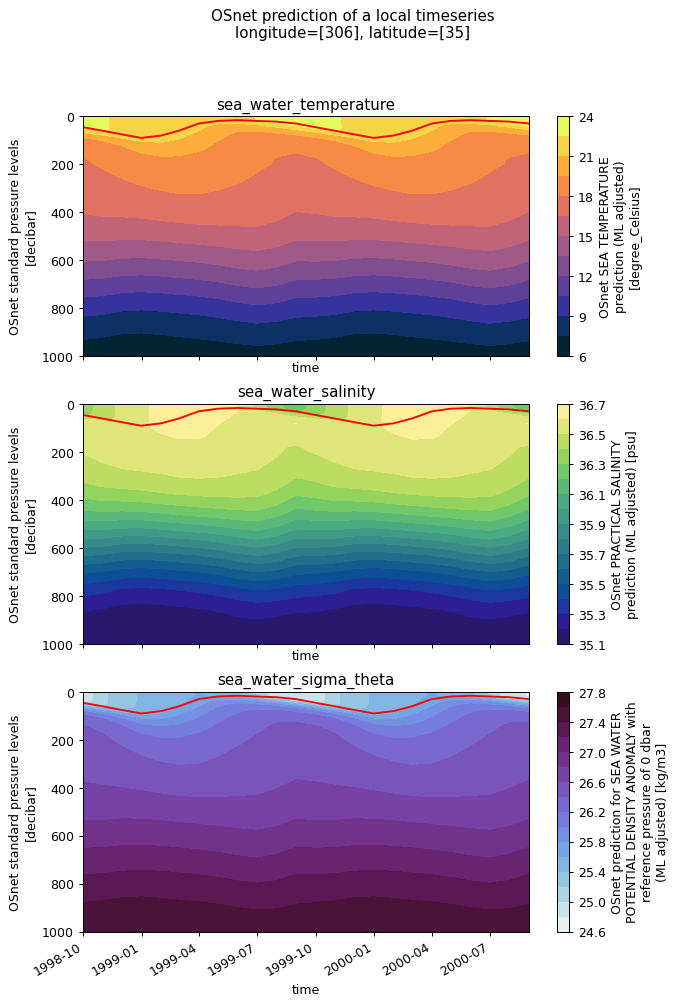

In [15]:
ds_out = output_list['local_timeseries']

if 'temp_adj' in ds_out:
    fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(8,12), dpi=90, sharex=True, sharey=True)
    ax = np.array(ax).flatten()
    vlist = ['temp_adj', 'psal_adj', 'sig_adj']
else:
    fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(20,7), dpi=90, sharex=True, sharey=True)
    ax = np.array(ax).flatten()
    vlist = ['temp', 'psal']
    
for i, v in enumerate(vlist):
    this = ds_out[v].isel(lat=0, lon=0)
    this.plot.contourf(x='time', ax=ax[i], levels=17, cmap=cmapd[v], yincrease=False)
    ax[i].plot(ds_out['time'], ds_out['mld'].isel(lat=0, lon=0), 'r')
    ax[i].set_title("%s" % this.attrs['standard_name'])
fig.suptitle('OSnet prediction of a local timeseries\nlongitude=%s, latitude=%s' % (ds_out['lon'].data, ds_out['lat'].data));

## 2D horizontal snapshot

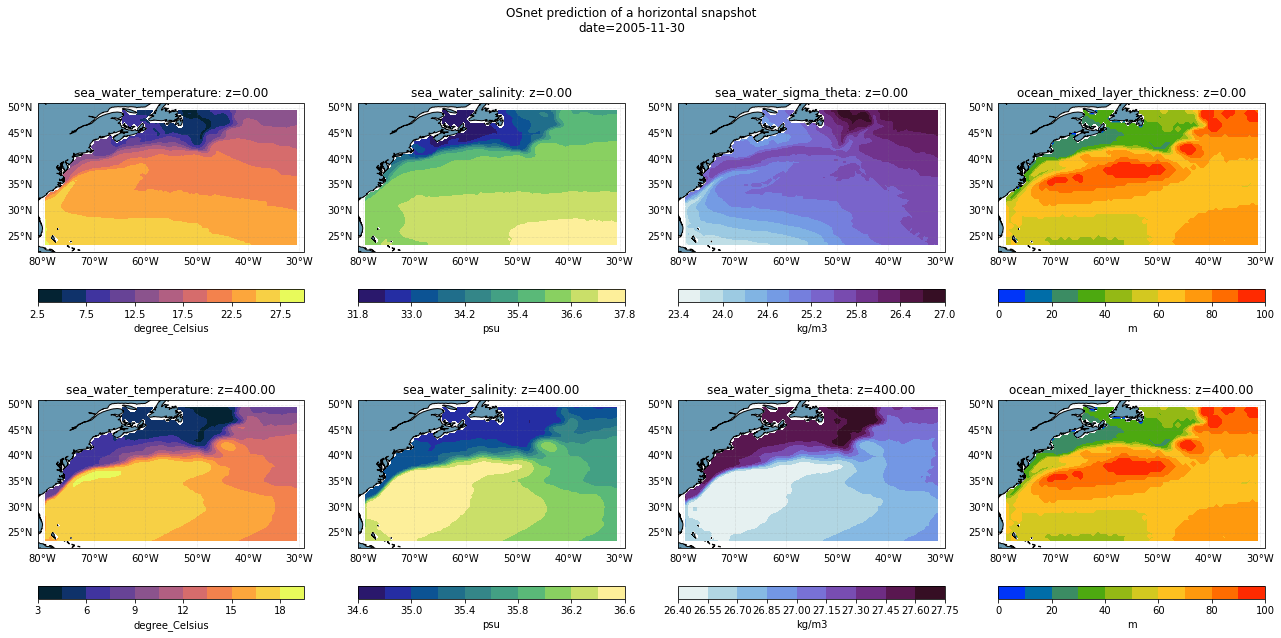

In [16]:
ds_out = output_list['snapshot']

if 'temp_adj' in ds_out:
    fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(22,10), sharex=True, sharey=True, subplot_kw={"projection": ccrs.PlateCarree()})
    ax = np.array(ax).flatten()
    vlist = ['temp_adj', 'psal_adj', 'sig_adj', 'mld']
else:
    fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20,10), sharex=True, sharey=True, subplot_kw={"projection": ccrs.PlateCarree()})
    ax = np.array(ax).flatten()
    vlist = ['temp', 'psal', 'mld']
    
for i, v in enumerate([(z,v) for z in [0, 400] for v in vlist]):
    z, vname = v[0], v[1]
    if 'PRES_INTERPOLATED' in ds_out[vname].dims:
        this = ds_out[vname].isel(time=0).sel(PRES_INTERPOLATED=z, method='nearest')
    else:
        this = ds_out[vname].isel(time=0)

    plot_map(ax[i])
    cs = this.plot.contourf(x='lon', ax=ax[i], levels=12, cmap=cmapd[vname], cbar_kwargs={'orientation':'horizontal', 'label':this.attrs['units']})
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_title("%s: z=%0.2f" % (this.attrs['standard_name'], z))
fig.suptitle('OSnet prediction of a horizontal snapshot\ndate=%s' % (pd.to_datetime(ds_out['time'].values[0]).strftime('%Y-%m-%d')));

## 2D meridional transect

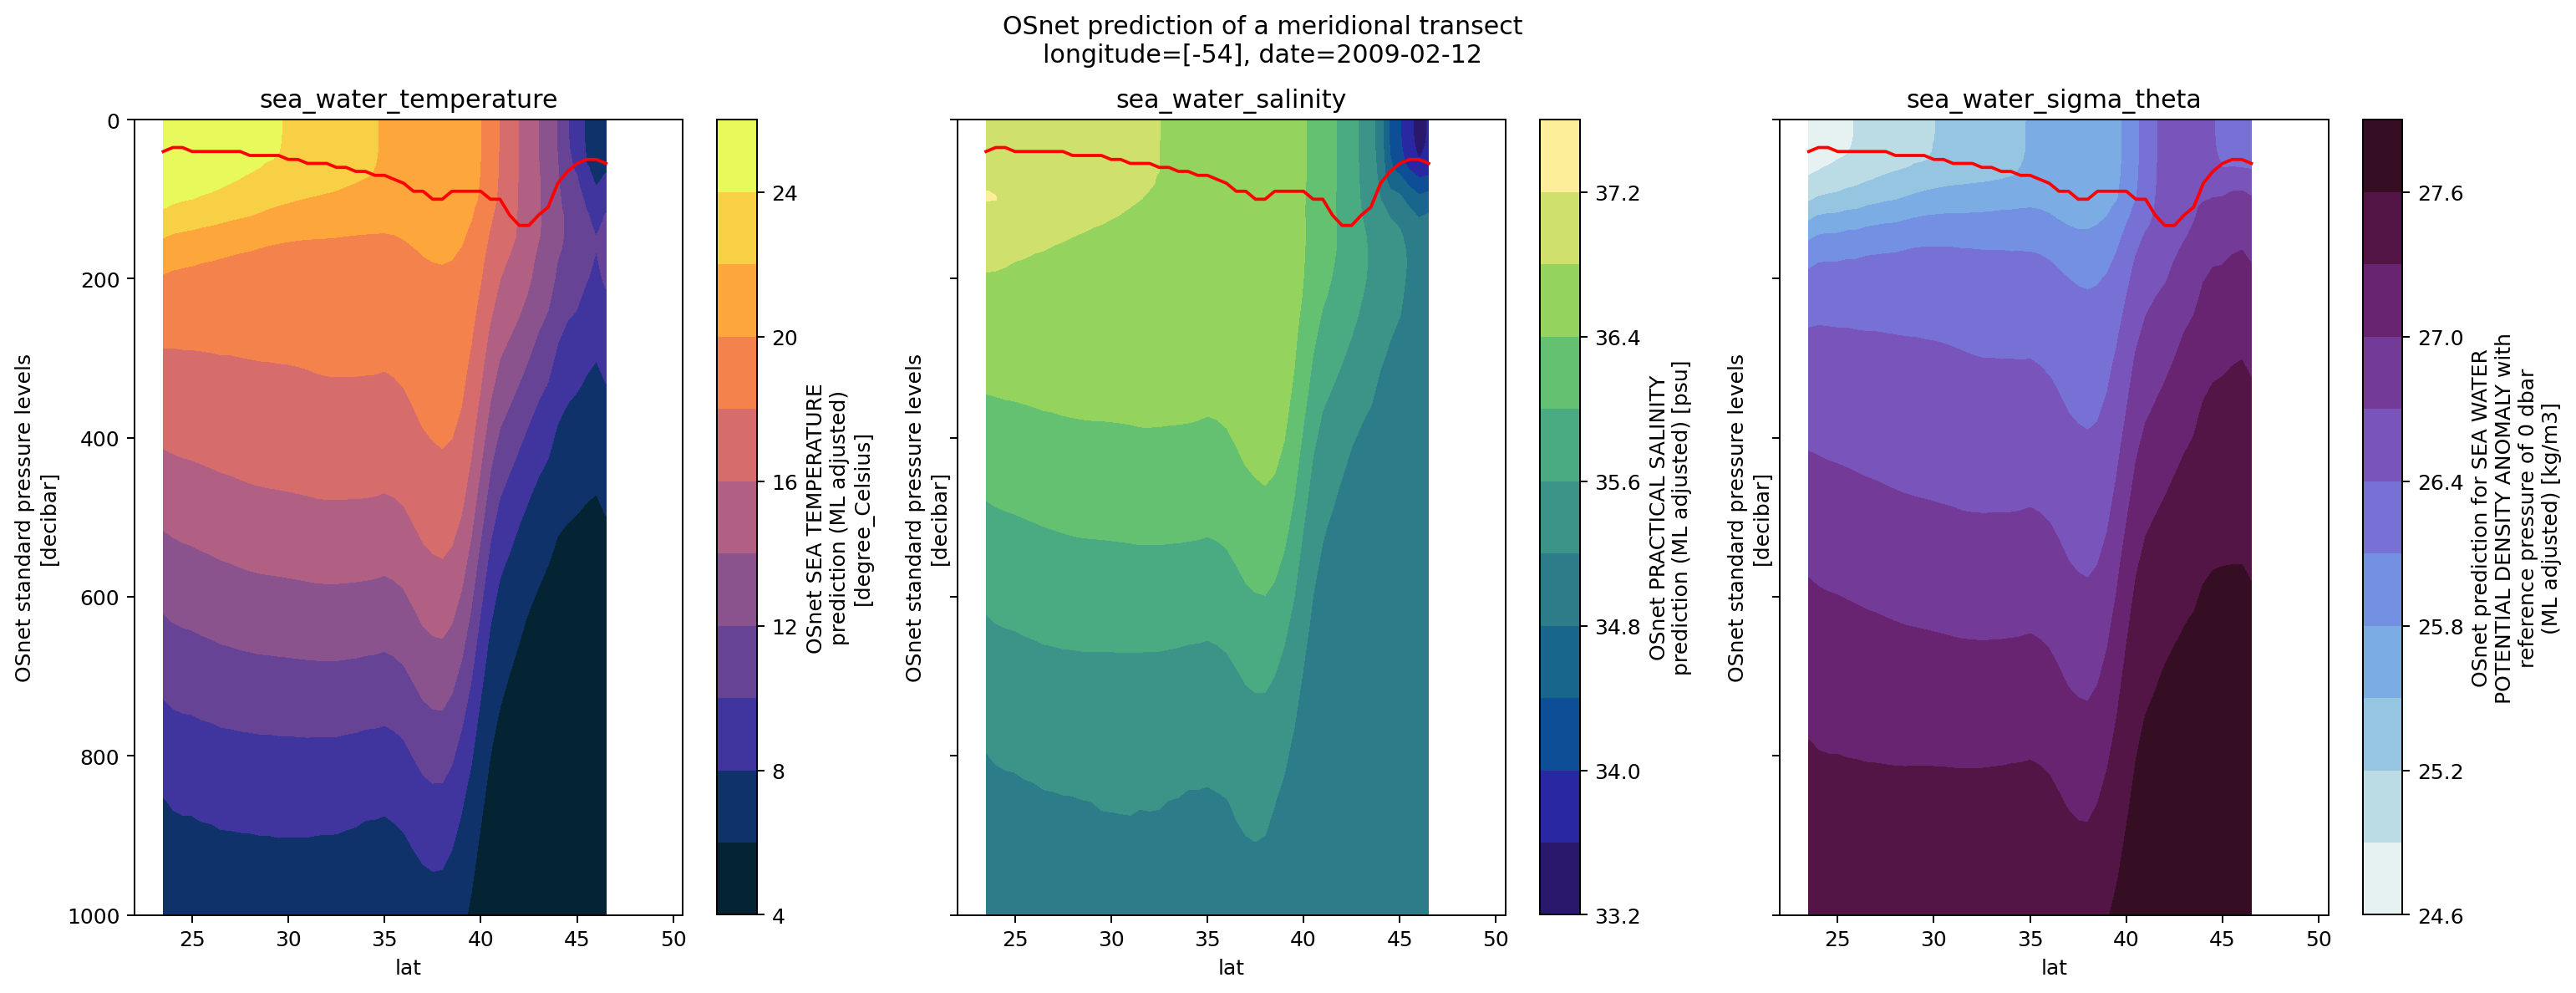

In [17]:
ds_out = output_list['meridional_transect']

if 'temp_adj' in ds_out:
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(20,7), dpi=180, sharex=True, sharey=True)
    ax = np.array(ax).flatten()
    vlist = ['temp_adj', 'psal_adj', 'sig_adj']
else:
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,7), dpi=180, sharex=True, sharey=True)
    ax = np.array(ax).flatten()
    vlist = ['temp', 'psal']
    
for i, v in enumerate(vlist):
    this = ds_out[v].isel(time=0, lon=0)
    this.plot.contourf(x='lat', ax=ax[i], levels=12, cmap=cmapd[v], yincrease=False)
    ax[i].plot(ds_out['lat'], ds_out['mld'].isel(time=0, lon=0), 'r')
#     ax[i].set_xlabel('')
#     ax[i].set_ylabel('')
    ax[i].set_title("%s" % this.attrs['standard_name'])
fig.suptitle('OSnet prediction of a meridional transect\nlongitude=%s, date=%s' % (ds_out['lon'].data, pd.to_datetime(ds_out['time'].values[0]).strftime('%Y-%m-%d')));

## 2D zonal transect

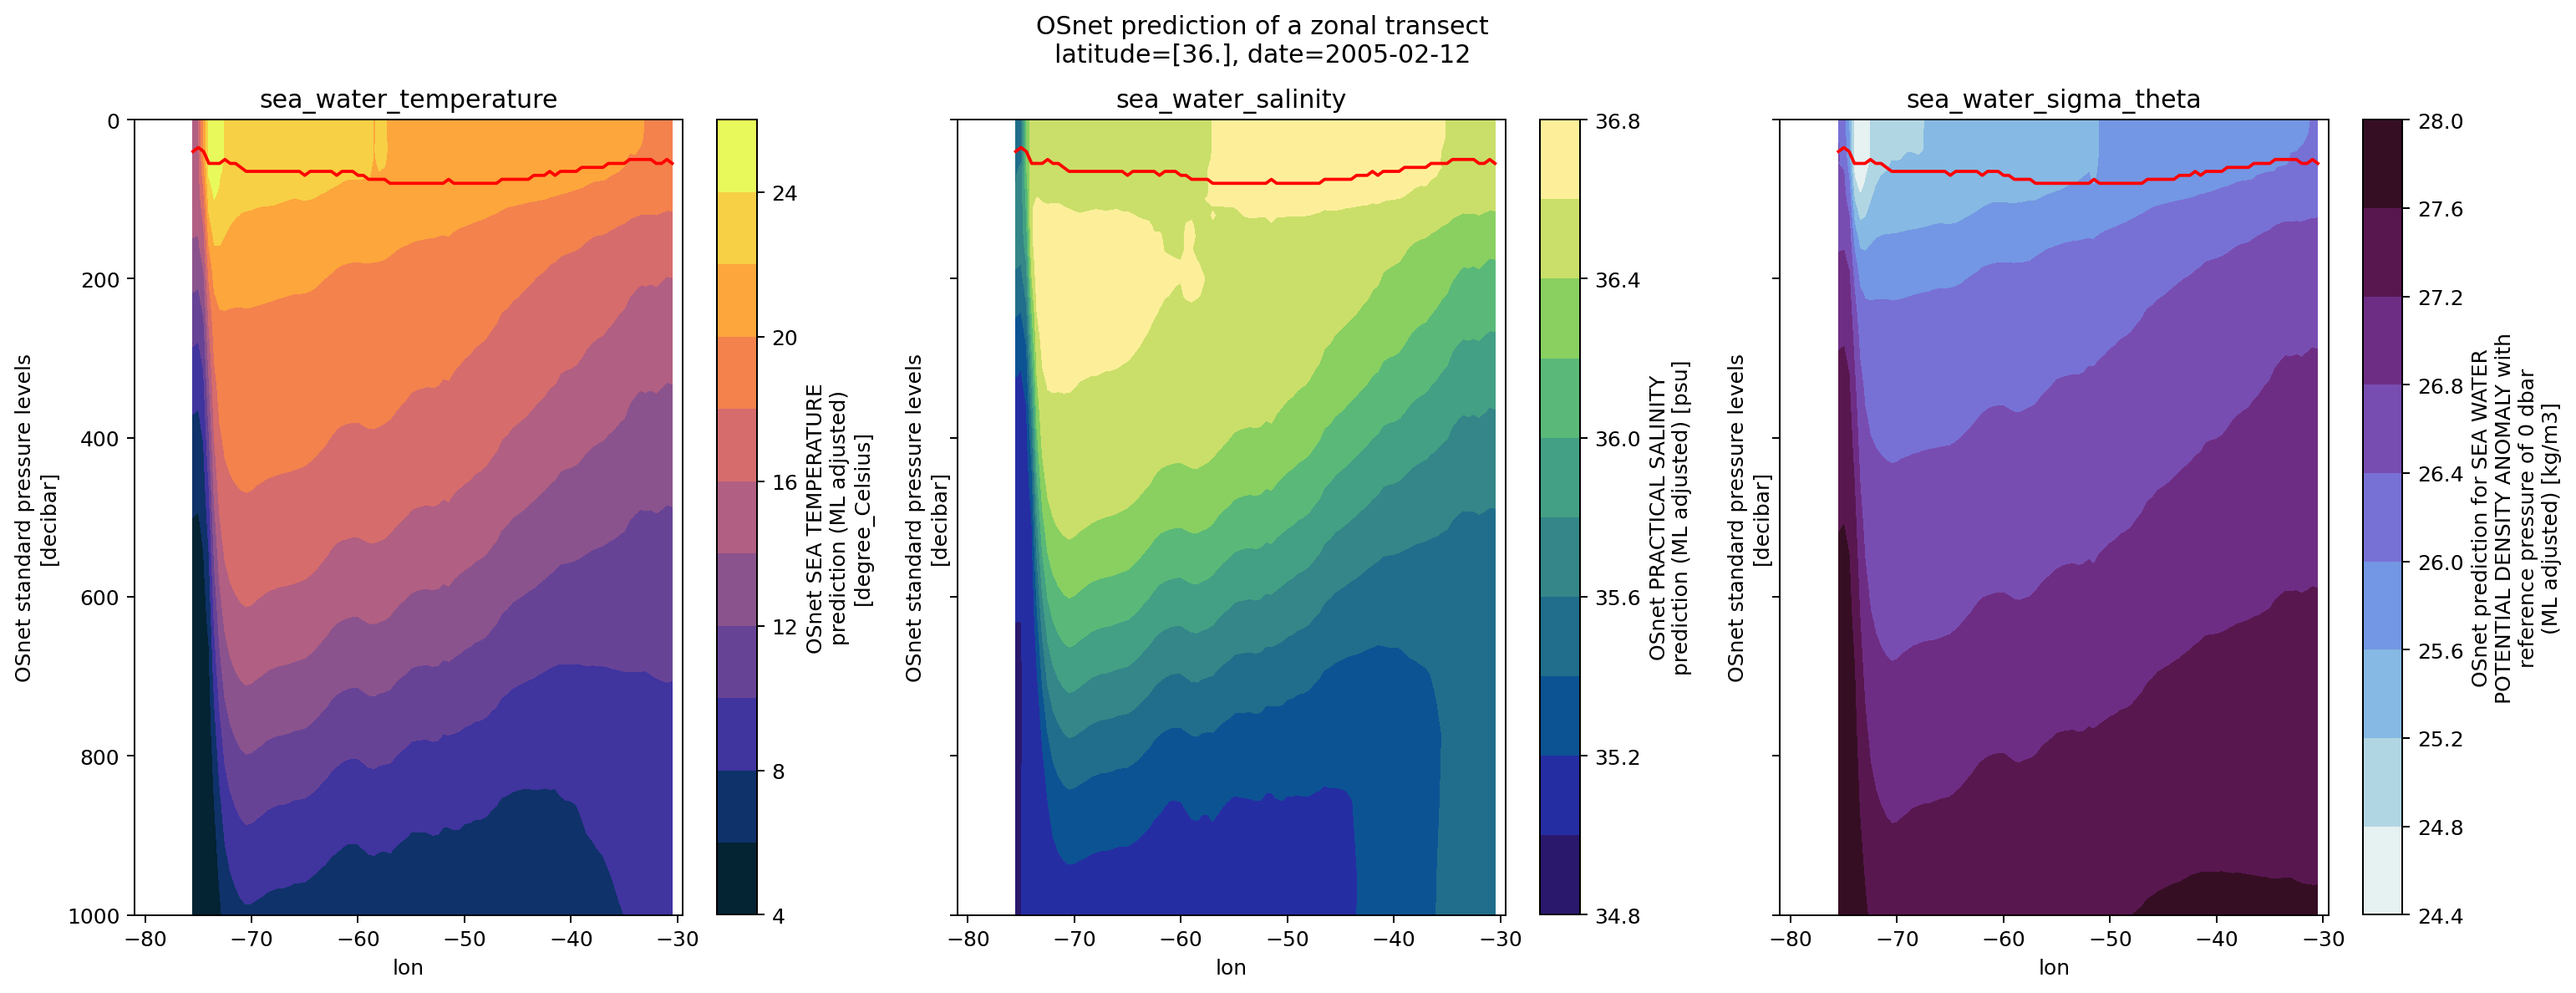

In [18]:
ds_out = output_list['zonal_transect']

if 'temp_adj' in ds_out:
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(20,7), dpi=180, sharex=True, sharey=True)
    ax = np.array(ax).flatten()
    vlist = ['temp_adj', 'psal_adj', 'sig_adj']
else:
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,7), dpi=180, sharex=True, sharey=True)
    ax = np.array(ax).flatten()
    vlist = ['temp', 'psal']
    
for i, v in enumerate(vlist):
    this = ds_out[v].isel(time=0, lat=0)
    this.plot.contourf(x='lon', ax=ax[i], levels=12, cmap=cmapd[v], yincrease=False)
    ax[i].plot(ds_out['lon'], ds_out['mld'].isel(time=0, lat=0), 'r')
    ax[i].set_title("%s" % this.attrs['standard_name'])
fig.suptitle('OSnet prediction of a zonal transect\nlatitude=%s, date=%s' % (ds_out['lat'].data, pd.to_datetime(ds_out['time'].values[0]).strftime('%Y-%m-%d')));    

## 2D along Argo float trajectory

Text(0.5, 0.98, 'OSnet prediction along profiles of an Argo float\nWMO=3901602')

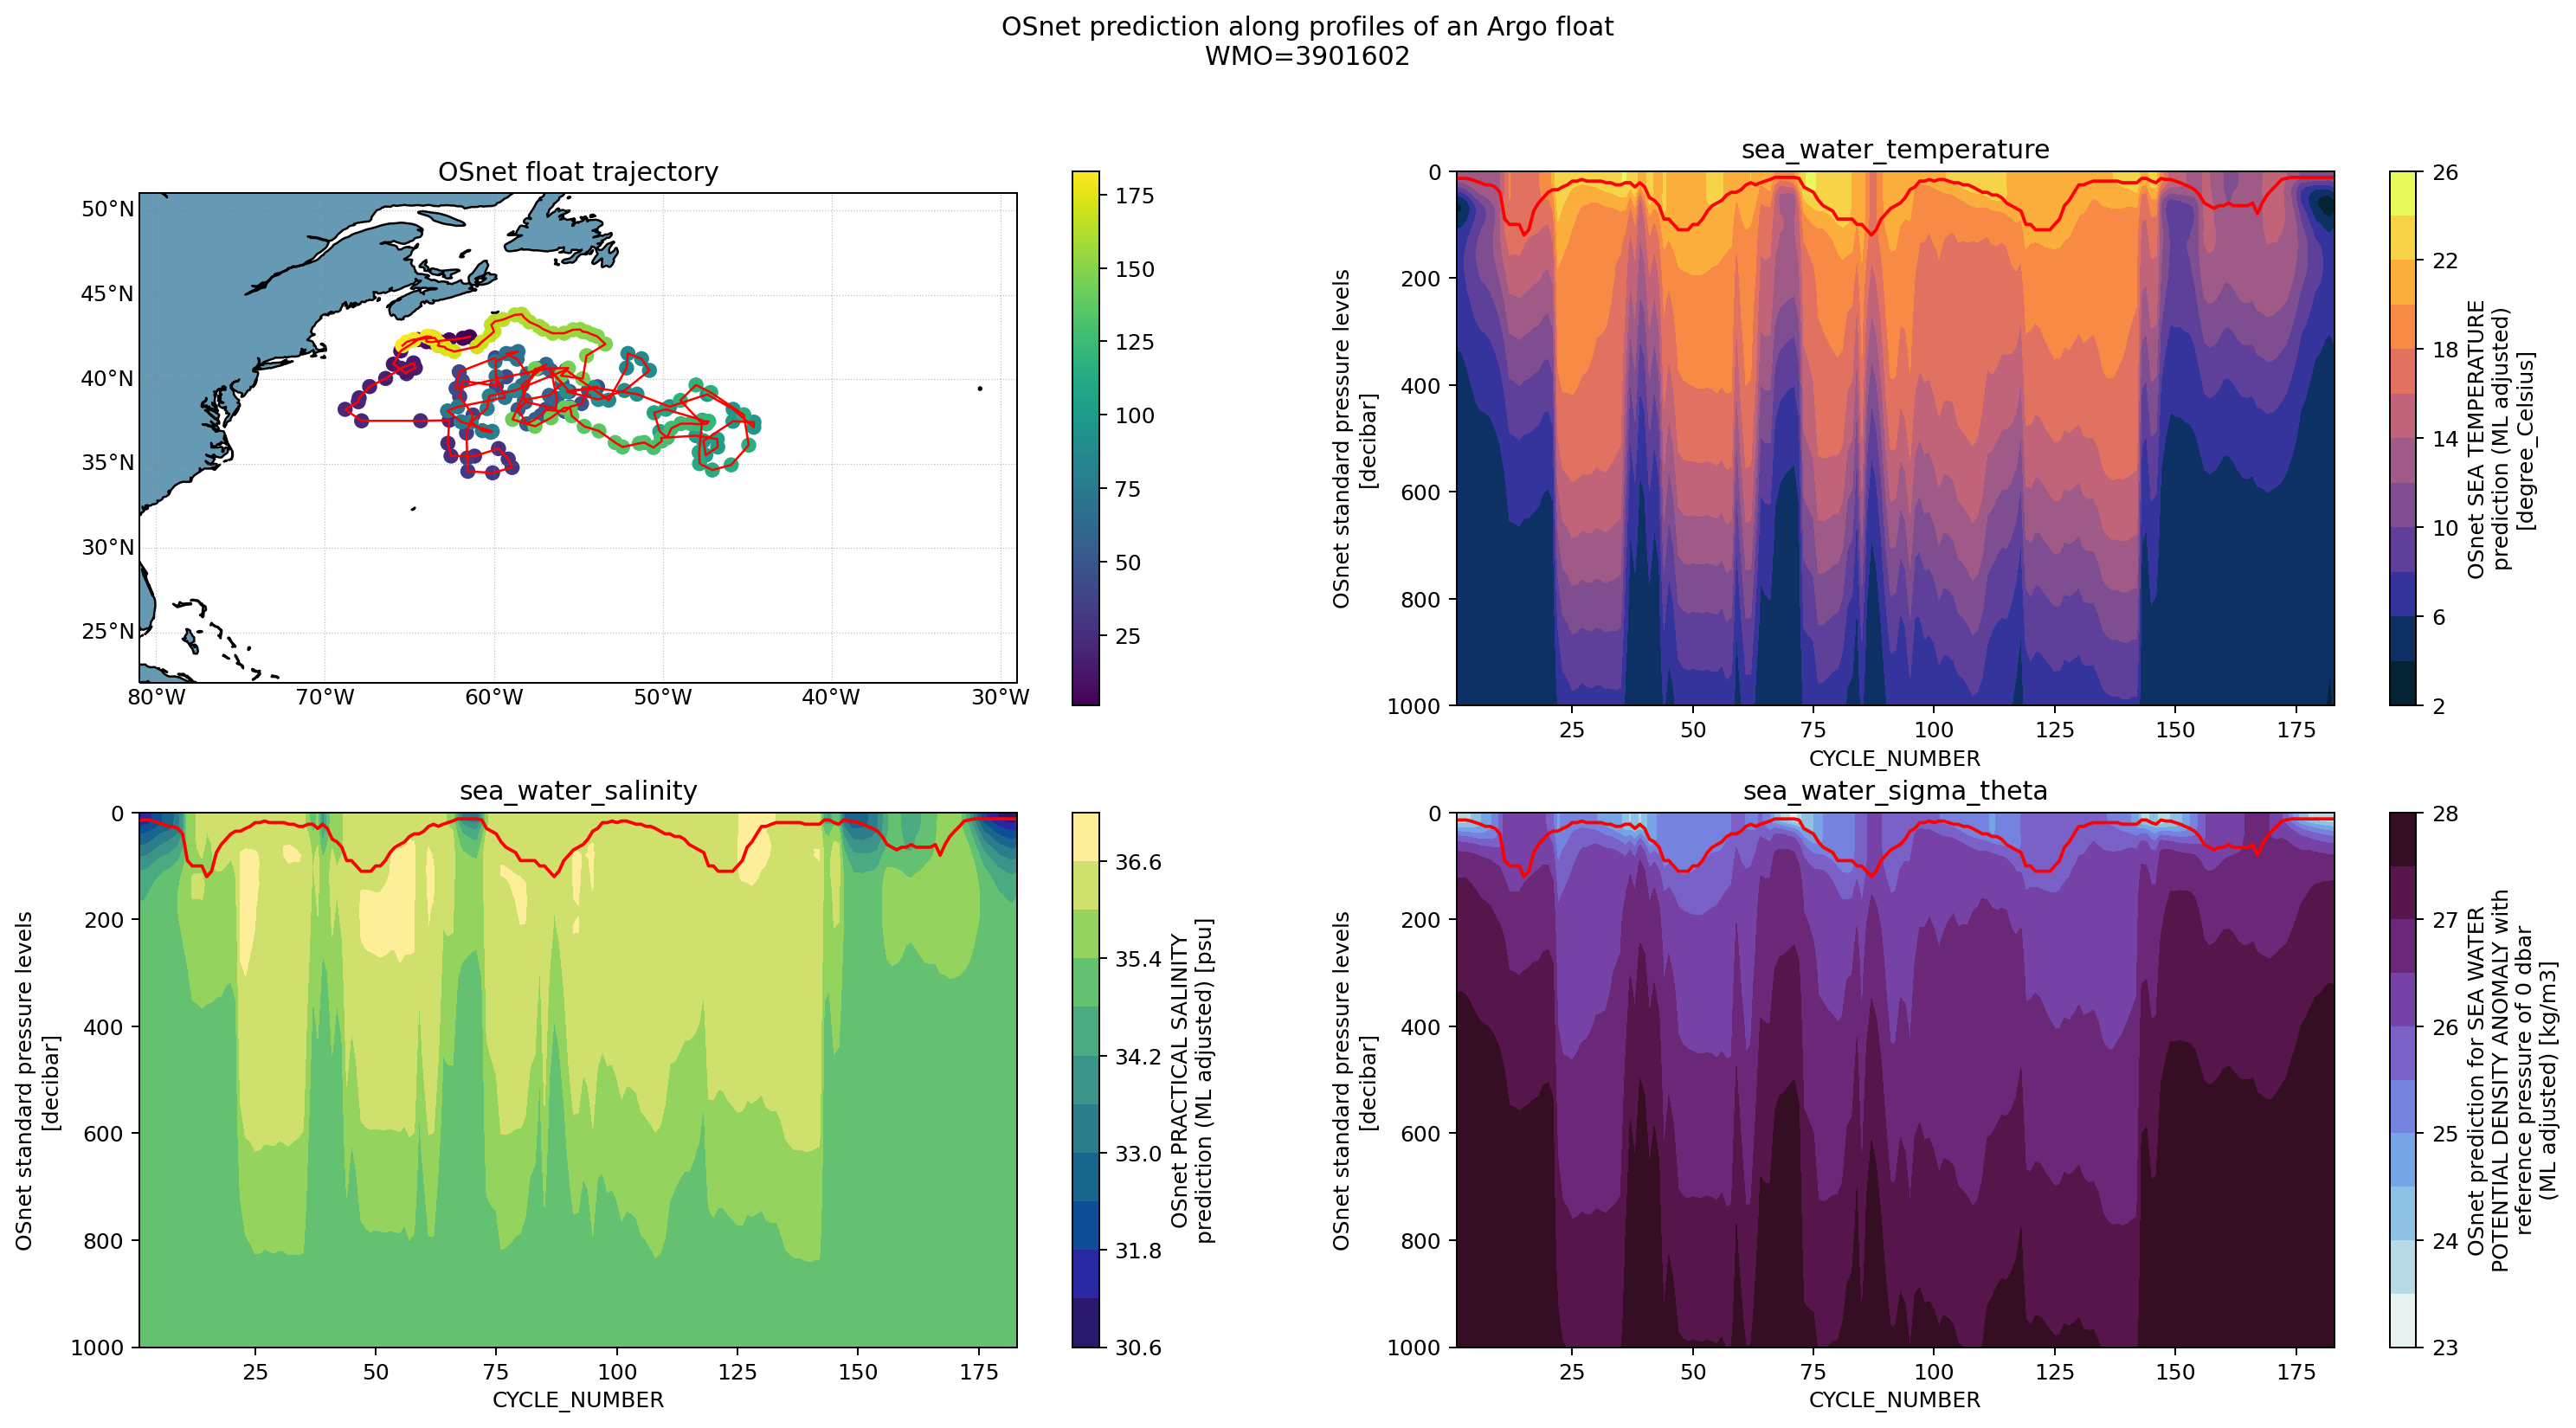

In [19]:
ds_out = output_list['argo_float']

fig = plt.figure(figsize=(20,10), dpi=180)
ax = []
ax.append(fig.add_subplot(221, projection=ccrs.PlateCarree()))
ax.append(fig.add_subplot(222))
ax.append(fig.add_subplot(223))
ax.append(fig.add_subplot(224))

plot_map(ax[0])
ax[0].plot(ds_out['lon'], ds_out['lat'], 'r', linewidth=1)
sc = ax[0].scatter(ds_out['lon'], ds_out['lat'], c=ds_out['CYCLE_NUMBER'])
plt.colorbar(sc, ax=ax[0])
ax[0].set_title('OSnet float trajectory')

vlist = ['temp_adj', 'psal_adj', 'sig_adj']
for i, v in enumerate(vlist):
    this = ds_out[v]#.isel(time=0, lat=0)
    this.plot.contourf(x='CYCLE_NUMBER', ax=ax[i+1], levels=12, cmap=cmapd[v], yincrease=False)
    ax[i+1].plot(ds_out['CYCLE_NUMBER'], ds_out['mld'], 'r')
    ax[i+1].set_title("%s" % this.attrs['standard_name'])
fig.suptitle('OSnet prediction along profiles of an Argo float\nWMO=%i' % 
             (np.unique(ds_float['PLATFORM_NUMBER'])[0]))

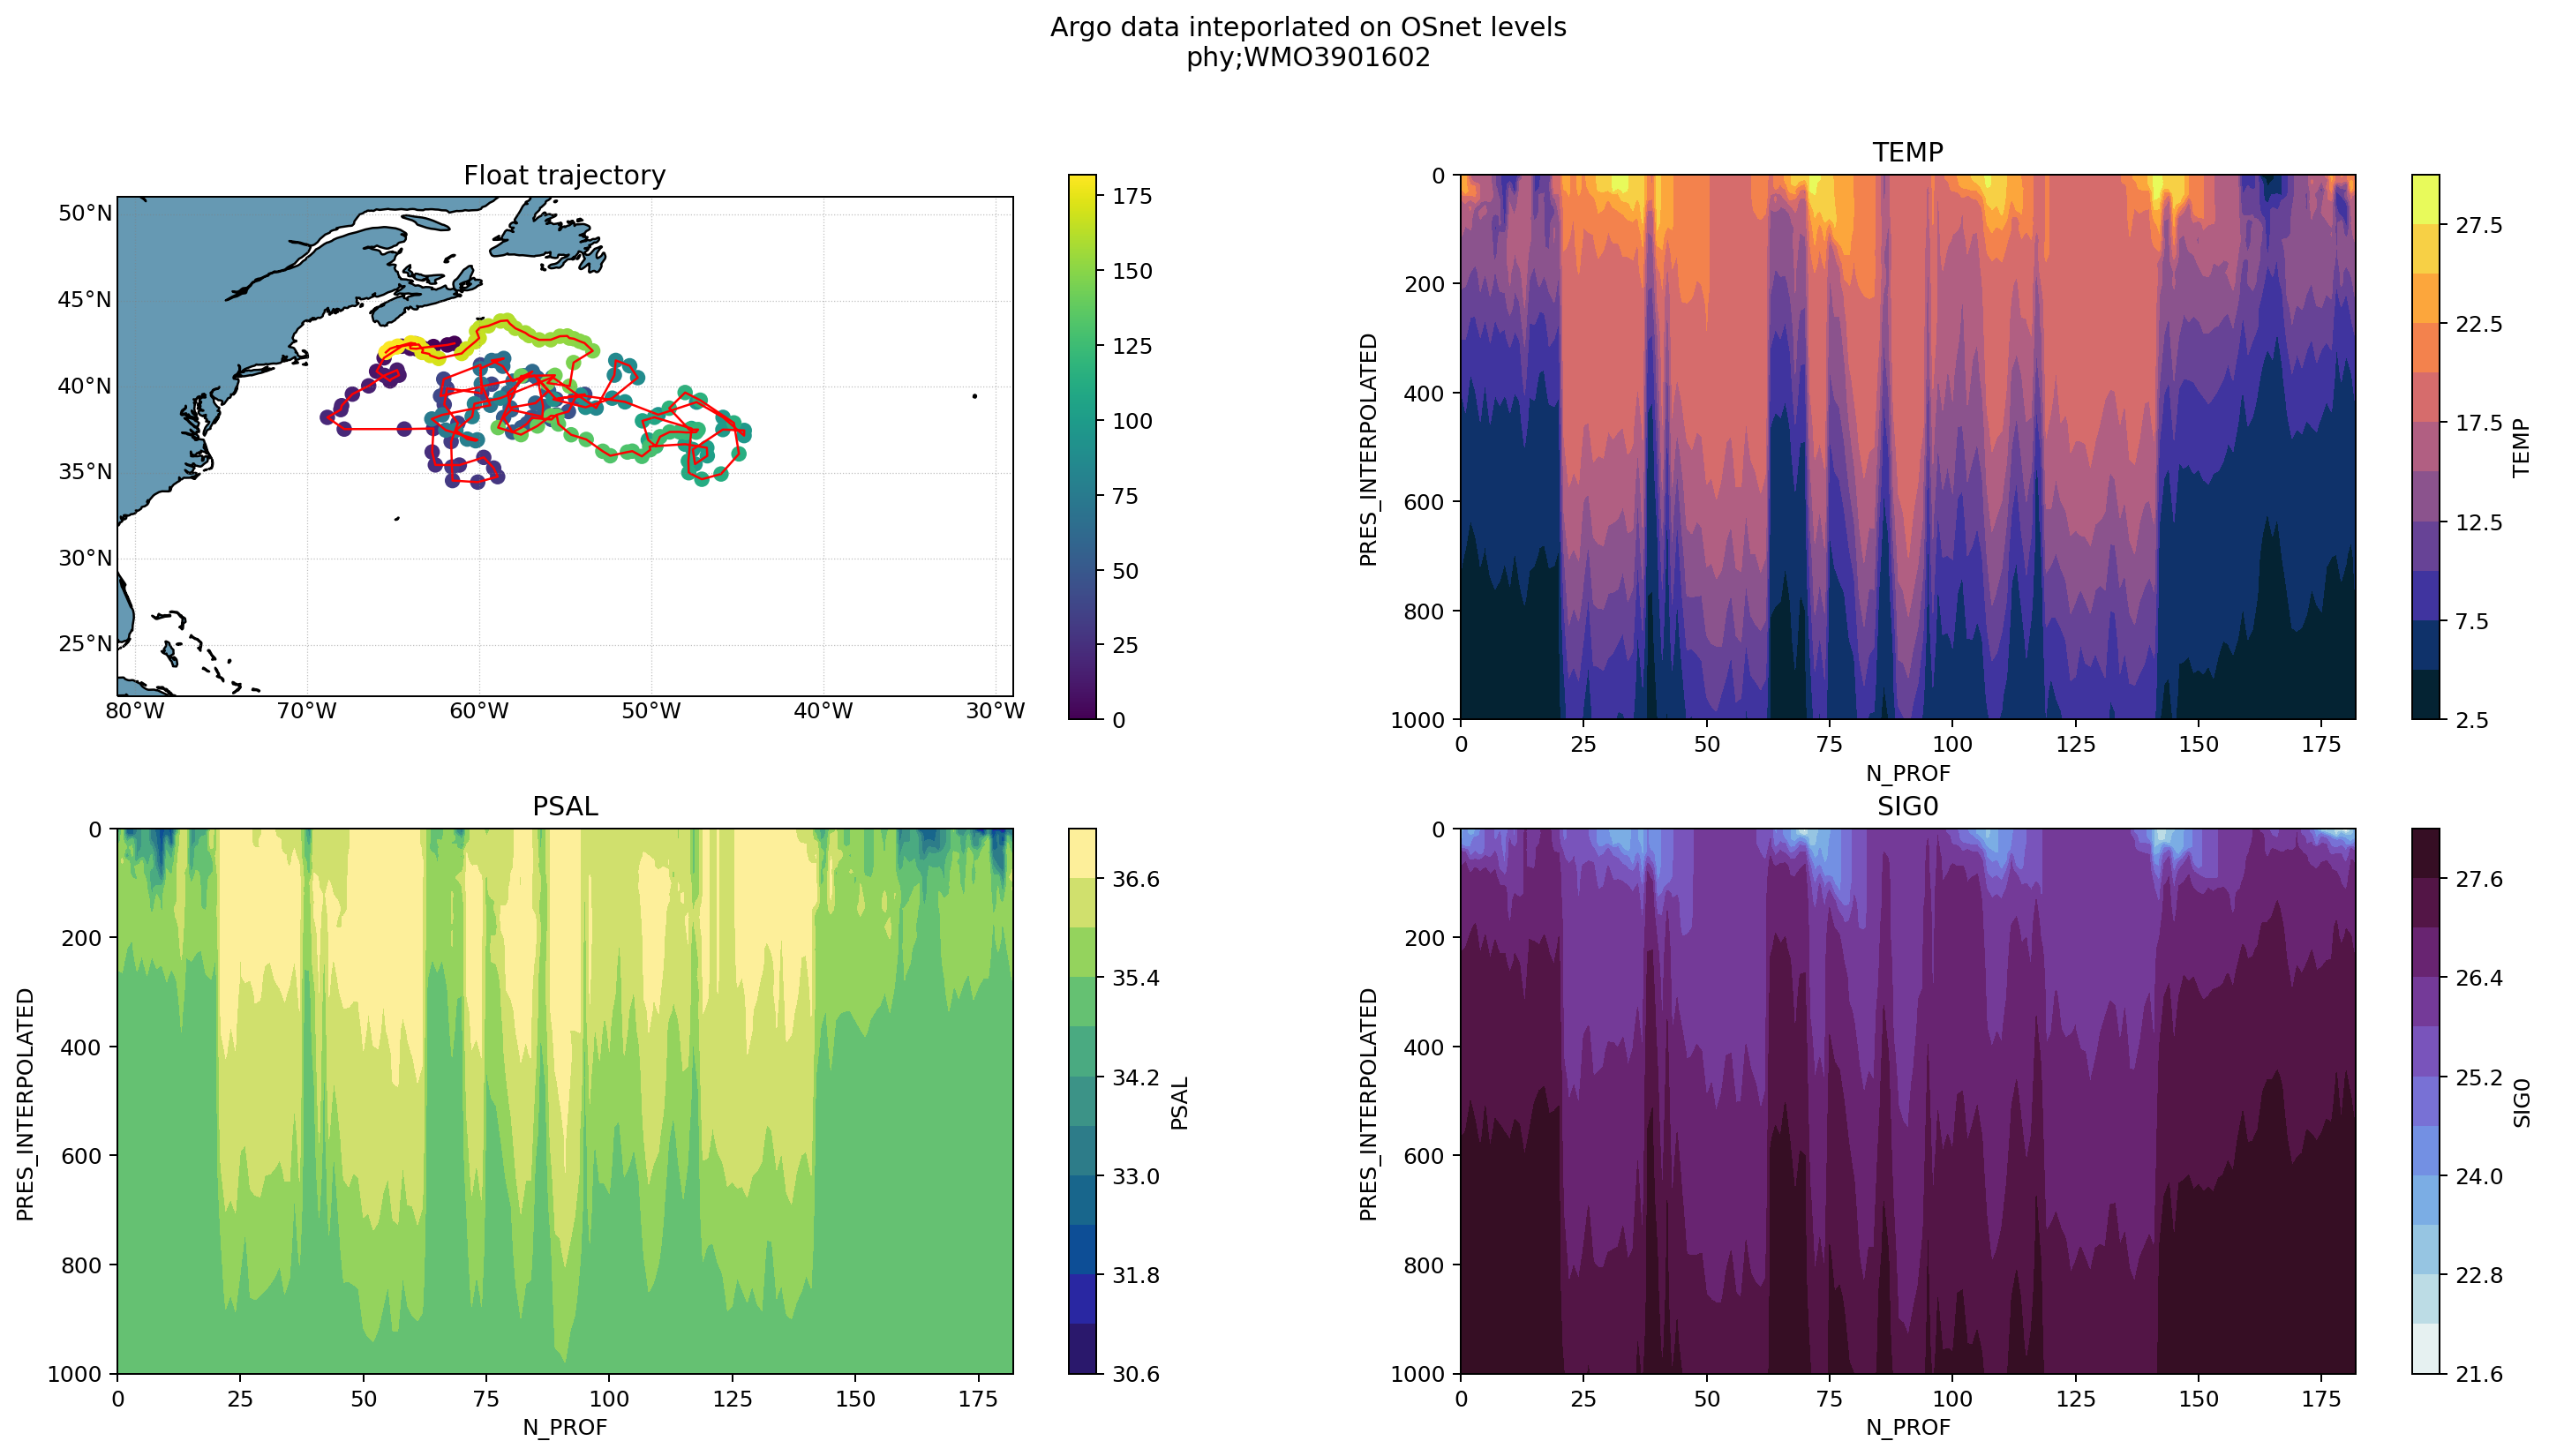

In [20]:
ds_float_i = ds_float.argo.teos10(['SIG0'], inplace=True).argo.interp_std_levels(m.SDL)

fig = plt.figure(figsize=(20,10), dpi=180)
ax = []
ax.append(fig.add_subplot(221, projection=ccrs.PlateCarree()))
ax.append(fig.add_subplot(222))
ax.append(fig.add_subplot(223))
ax.append(fig.add_subplot(224))

plot_map(ax[0])
ax[0].plot(ds_float['LONGITUDE'], ds_float['LATITUDE'], 'r', linewidth=1)
sc = ax[0].scatter(ds_float['LONGITUDE'], ds_float['LATITUDE'], c=ds_float['N_PROF'])
plt.colorbar(sc, ax=ax[0])
ax[0].set_title('Float trajectory')

vlist = ['TEMP', 'PSAL', 'SIG0']    
for i, v in enumerate(vlist):
    this = ds_float_i[v]#.isel(time=0, lat=0)
    this.plot.contourf(x='N_PROF', ax=ax[i+1], levels=12, cmap=cmapd[v.lower().replace('sig0','sig')], yincrease=False)
    ax[i+1].set_title("%s" % v)
fig.suptitle('Argo data inteporlated on OSnet levels\n%s' % ds_float.attrs['Fetched_constraints']);

In [21]:
insert_img = lambda url: "<img src='%s' style='height:75px'>" % url
insert_link = lambda url, txt: "<a href='%s'>%s</a>" % (url, txt)

html = "<p>This notebook has been developed at the Laboratory for Ocean Physics and Satellite remote sensing, Ifremer, \
within the framework of the Euro-ArgoRISE project. This project has received funding from the European \
Union’s Horizon 2020 research and innovation programme under grant agreement no 824131. Call INFRADEV-03-2018-2019: \
Individual support to ESFRI and other world-class research infrastructures.</p>"

l1 = insert_link("https://www.euro-argo.eu/EU-Projects/Euro-Argo-RISE-2019-2022", 
            insert_img("https://user-images.githubusercontent.com/59824937/146353317-56b3e70e-aed9-40e0-9212-3393d2e0ddd9.png"))

l2 = insert_link("https://www.umr-lops.fr", 
            insert_img("https://user-images.githubusercontent.com/59824937/146353157-b45e9943-9643-45d0-bab5-80c22fc2d889.jpg"))

l3 = insert_link("https://wwz.ifremer.fr", 
            insert_img("https://user-images.githubusercontent.com/59824937/146353099-bcd2bd4e-d310-4807-aee2-9cf24075f0c3.jpg"))

from IPython.core.display import HTML
HTML("<hr>" + html + l1 + l2 + l3)

In [22]:
from IPython.core.display import display

/var/folders/ww/psmkfjds7xsc4kjsz66ghldr000nsn/T/ipykernel_45053/1726750586.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [23]:
display(html)

'<p>This notebook has been developed at the Laboratory for Ocean Physics and Satellite remote sensing, Ifremer, within the framework of the Euro-ArgoRISE project. This project has received funding from the European Union’s Horizon 2020 research and innovation programme under grant agreement no 824131. Call INFRADEV-03-2018-2019: Individual support to ESFRI and other world-class research infrastructures.</p>'